<a href="https://colab.research.google.com/github/Sahana-D-01/Detection-and-Prediction-of-PCOS/blob/main/CIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset used:** 
Polycystic ovary syndrome (PCOS) - from kaggle

**Link to dataset:** https://www.kaggle.com/datasets/prasoonkottarathil/polycystic-ovary-syndrome-pcos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download prasoonkottarathil/polycystic-ovary-syndrome-pcos

  0% 0.00/120k [00:00<?, ?B/s]
100% 120k/120k [00:00<00:00, 59.4MB/s]


In [ ]:
! mkdir pcos_dataset

In [ ]:
! unzip polycystic-ovary-syndrome-pcos.zip -d pcos_dataset

Archive:  polycystic-ovary-syndrome-pcos.zip
  inflating: pcos_dataset/PCOS_data_without_infertility.xlsx  
  inflating: pcos_dataset/PCOS_infertility.csv  


In [ ]:
import csv
import pandas as pd
import re
import tensorflow as tf
import numpy as np

In [ ]:
#Importing all the libraries that I use in this project
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## **Module 1 - Data Preprocessing**



In [ ]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Loading data into the kernels 

file_path_with_infertility="/content/pcos_dataset/PCOS_infertility.csv"
file_path_without_infertility="/content/pcos_dataset/PCOS_data_without_infertility.xlsx"

PCOS_inf = pd.read_csv(file_path_with_infertility)
PCOS_woinf = pd.read_excel(file_path_without_infertility, sheet_name="Full_new")

In [ ]:
#Merging the two files as per patient file no. 
#The files were sorted into two based on patients with infertility and without infertility
data = pd.merge(PCOS_woinf,PCOS_inf, on='Patient File No.', suffixes={'','_y'},how='left')

#Dropping the repeated features after merging
data =data.drop(['Unnamed: 44', 'Sl. No_y', 'PCOS (Y/N)_y', '  I   beta-HCG(mIU/mL)_y',
       'II    beta-HCG(mIU/mL)_y', 'AMH(ng/mL)_y'], axis=1)

#Taking a look at the dataset
data.head() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing 'suffixes' as a <class 'set'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  This is separate from the ipykernel package so we can avoid doing imports until


,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1.0,1.0,0.0,28.0,44.6,152.0,19.300000,15.0,78.0,22.0,...,0.0,1.0,0.0,110.0,80.0,3.0,3.0,18.0,18.0,8.5
1,2.0,2.0,0.0,36.0,65.0,161.5,24.921163,15.0,74.0,20.0,...,0.0,0.0,0.0,120.0,70.0,3.0,5.0,15.0,14.0,3.7
2,3.0,3.0,1.0,33.0,68.8,165.0,25.270891,11.0,72.0,18.0,...,1.0,1.0,0.0,120.0,80.0,13.0,15.0,18.0,20.0,10.0
3,4.0,4.0,0.0,37.0,65.0,148.0,29.674945,13.0,72.0,20.0,...,0.0,0.0,0.0,120.0,70.0,2.0,2.0,15.0,14.0,7.5
4,5.0,5.0,0.0,25.0,52.0,161.0,20.060954,11.0,72.0,18.0,...,0.0,0.0,0.0,120.0,80.0,3.0,4.0,16.0,14.0,7.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    float64
 1   Patient File No.        541 non-null    float64
 2   PCOS (Y/N)              541 non-null    float64
 3    Age (yrs)              541 non-null    float64
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     541 non-null    float64
 7   Blood Group             541 non-null    float64
 8   Pulse rate(bpm)         541 non-null    float64
 9   RR (breaths/min)        541 non-null    float64
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    float64
 12  Cycle length(days)      541 non-null    float64
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    fl

In [ ]:
#Having a look at the data with dtype objects
data["AMH(ng/mL)"].head() 

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [ ]:
#Similarly
data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

In [ ]:
#Dealing with categorical values.
#In this database the type objects are numeric values saved as strings.
#So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

#Dealing with missing values. 
#Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

#Clearing up the extra space in the column names (optional)
data.columns = [col.strip() for col in data.columns]

## **Module 2 - Exploratory Data Analysis**

In [ ]:
# Having a look at some basic statistical details.
data.describe()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,271.000000,271.000000,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,156.317519,156.317519,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,1.000000,1.000000,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.000000,136.000000,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,271.000000,271.000000,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,406.000000,406.000000,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,541.000000,541.000000,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


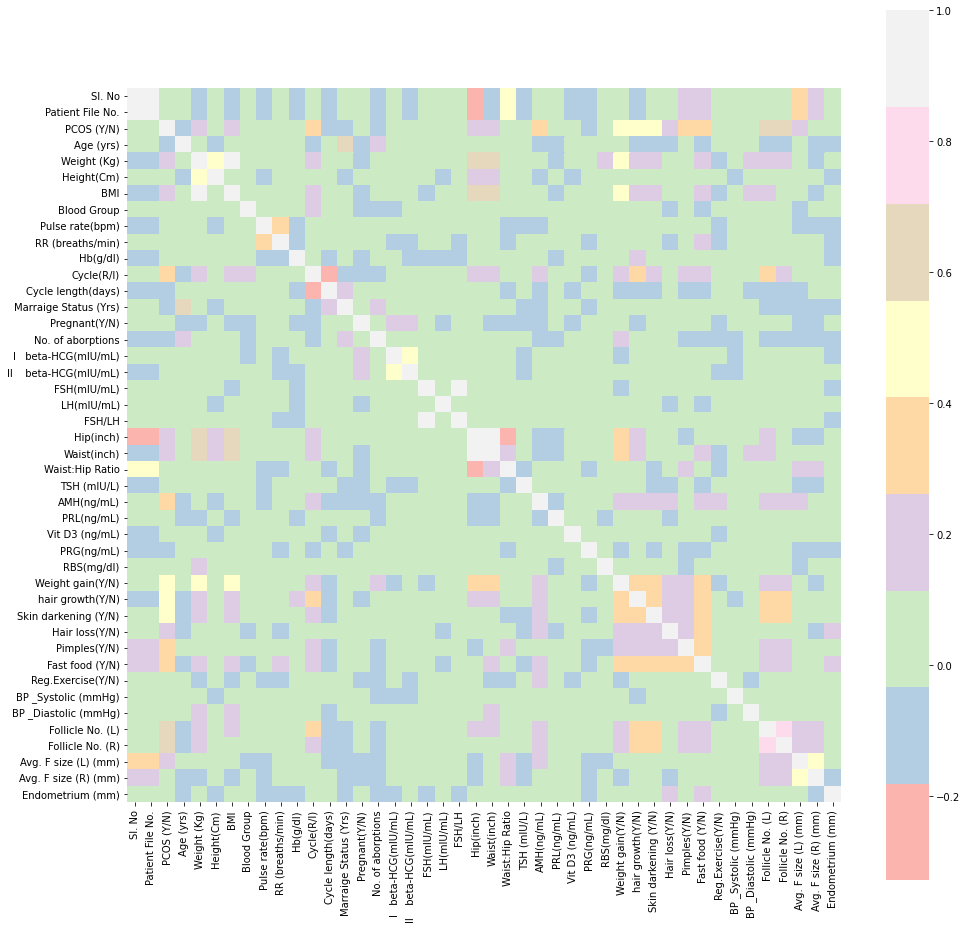

In [ ]:
#Examining a correlation matrix of all the features 
corrmat = data.corr()
plt.subplots(figsize=(16,16))
sns.heatmap(corrmat,cmap="Pastel1", square=True);

In [ ]:
#How all the features correlate with the PCOS 
corrmat["PCOS (Y/N)"].sort_values(ascending=False)

PCOS (Y/N)                1.000000
Follicle No. (R)          0.648327
Follicle No. (L)          0.603346
Skin darkening (Y/N)      0.475733
hair growth(Y/N)          0.464667
Weight gain(Y/N)          0.441047
Cycle(R/I)                0.401644
Fast food (Y/N)           0.376183
Pimples(Y/N)              0.286077
AMH(ng/mL)                0.264141
Weight (Kg)               0.211938
BMI                       0.199534
Hair loss(Y/N)            0.172879
Waist(inch)               0.164598
Hip(inch)                 0.162297
Avg. F size (L) (mm)      0.132992
Endometrium (mm)          0.106648
Avg. F size (R) (mm)      0.097690
Pulse rate(bpm)           0.091821
Hb(g/dl)                  0.087170
Vit D3 (ng/mL)            0.085494
Height(Cm)                0.068254
Reg.Exercise(Y/N)         0.065337
LH(mIU/mL)                0.063879
Sl. No                    0.060998
Patient File No.          0.060998
RBS(mg/dl)                0.048922
BP _Diastolic (mmHg)      0.038032
RR (breaths/min)    

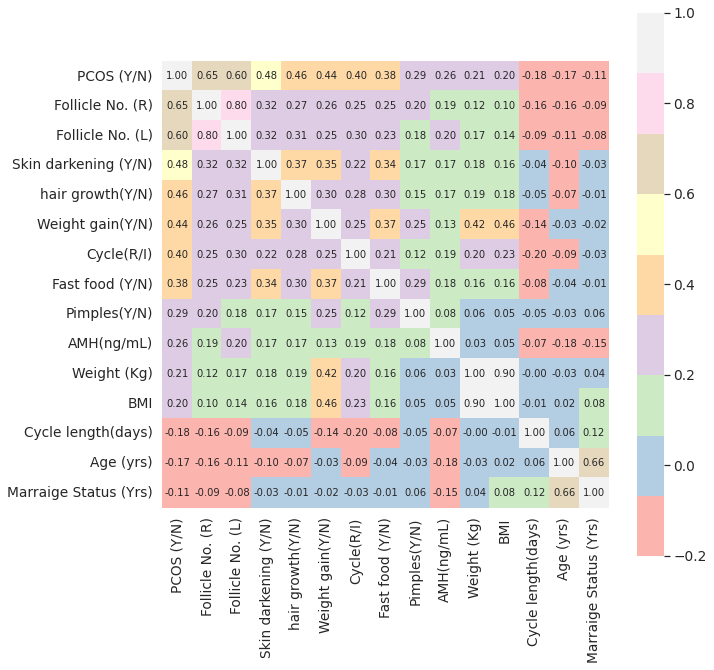

In [ ]:
#Having a look at features bearing significant correlation

plt.figure(figsize=(10,10))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k, "PCOS (Y/N)")["PCOS (Y/N)"].index 
cols_n = corrmat.nsmallest(l, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols = cols_p.append(cols_n) 

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Pastel1", annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## **Module 3 - Visualization of the Data**

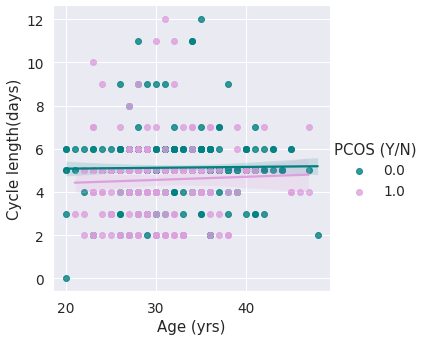

In [ ]:
# Length of menstrual phase in PCOS vs normal 
color = ["teal", "plum"]
fig=sns.lmplot(data=data,x="Age (yrs)",y="Cycle length(days)", hue="PCOS (Y/N)",palette=color)
plt.show(fig)

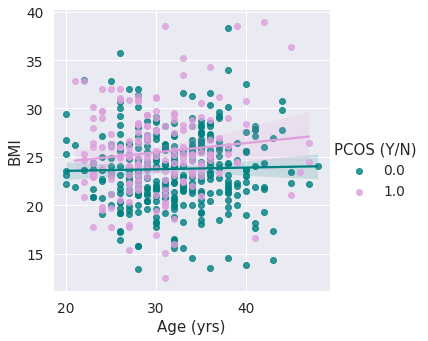

In [ ]:
# Pattern of weight gain (BMI) over years in PCOS and Normal. 
fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="PCOS (Y/N)", palette= color )
plt.show(fig)

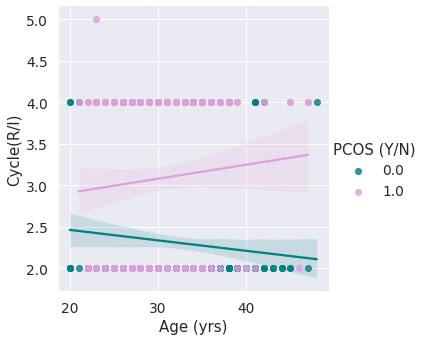

In [ ]:
# cycle IR wrt age 
sns.lmplot(data =data,x="Age (yrs)",y="Cycle(R/I)", hue="PCOS (Y/N)",palette=color)
plt.show()

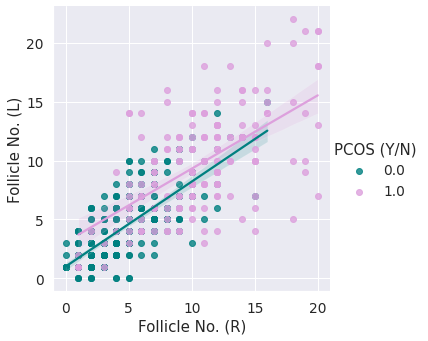

In [ ]:
# Distribution of follicles in both ovaries. 
sns.lmplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="PCOS (Y/N)",palette=color)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


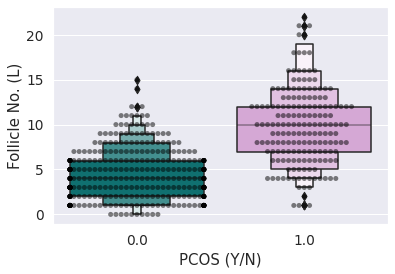

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 34.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


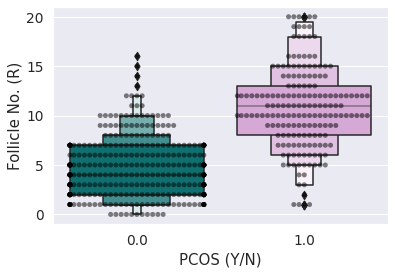

In [ ]:
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

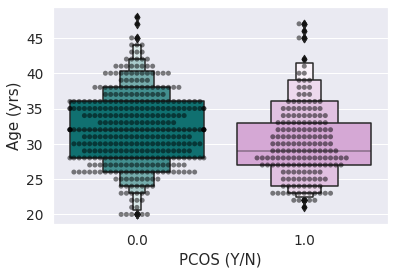

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 12.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


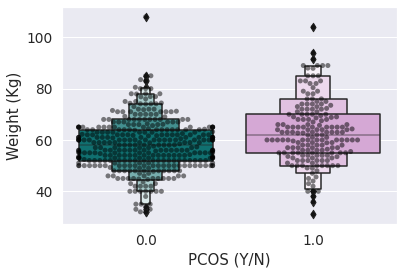

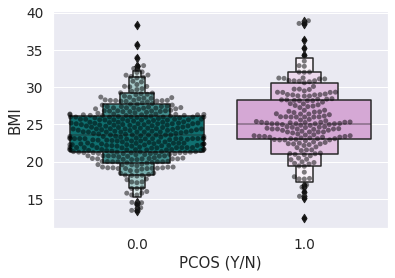

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 25.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


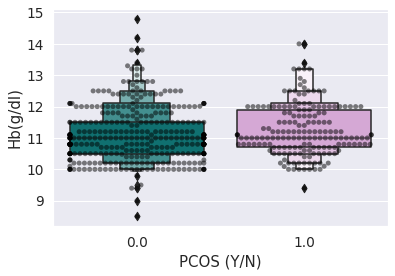

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 66.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 29.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


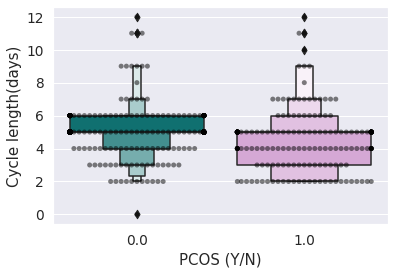

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 19.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


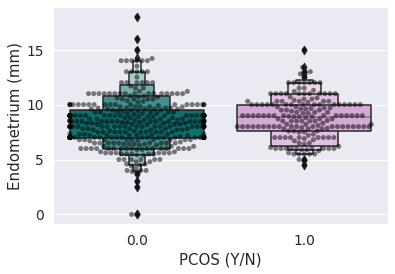

In [ ]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

## **Module 4 - Model Building**
In this module, we compare the outputs of two classifiers:

*   Random Forest
*   Hybrid Random Forest Logistic Regression



#### **1. Random Forest Classifier**

In [ ]:
#Assiging the features (X)and target(y)

X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
y=data["PCOS (Y/N)"]

#Splitting the data into test and training sets

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3) 

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Fitting the RandomForestClassifier to the training set

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

#Making prediction and checking the test set

pred_rfc = rfc.predict(X_test)
accuracy = accuracy_score(y_test, pred_rfc)
print(accuracy)

0.9141104294478528


In [ ]:
from sklearn.metrics import confusion_matrix

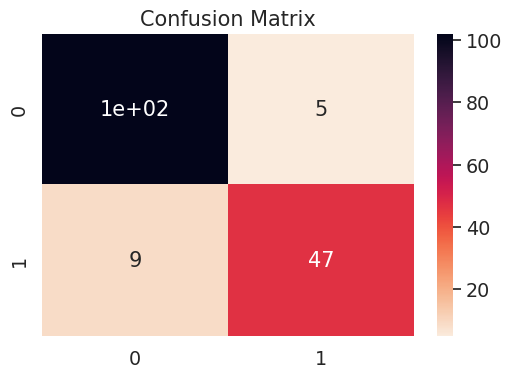

In [ ]:
plt.figure(dpi = 100)
plt.title("Confusion Matrix")
cf_matrix = confusion_matrix(y_test, pred_rfc)
cf_hm = sns.heatmap(cf_matrix, annot=True, cmap = 'rocket_r')

In [ ]:
classi_report = classification_report(y_test, pred_rfc)
print(classi_report)

              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       107
         1.0       0.90      0.84      0.87        56

    accuracy                           0.91       163
   macro avg       0.91      0.90      0.90       163
weighted avg       0.91      0.91      0.91       163



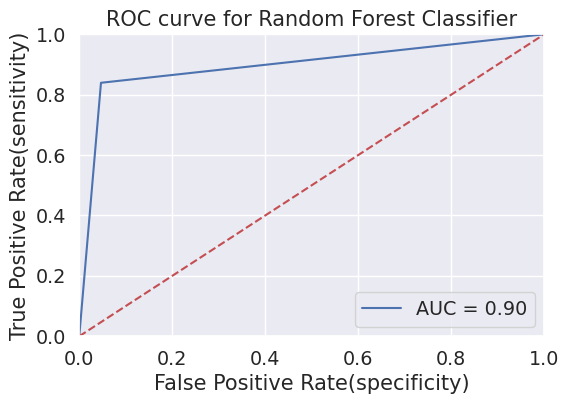

In [ ]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, pred_rfc)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(dpi = 100)
plt.title('ROC curve for Random Forest Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate(sensitivity)')
plt.xlabel('False Positive Rate(specificity)')
plt.show()

In [ ]:
X_test.iloc[0]
print(len(X_test.iloc[0]))

41


In [ ]:
import random

rand_test = []
for i in range(41):
  rand_test.append(random.uniform(-1, 2))

len(rand_test)

41

In [ ]:
np.array(rand_test).reshape(1, -1)

array([[ 1.78347812,  1.46881678,  1.22792561, -0.39784061,  1.29757392,
         1.70615627,  0.77966771,  1.20609998, -0.92684586,  1.11928559,
         0.99296864,  0.08956457,  1.42000779,  0.11819407, -0.32397846,
        -0.49453608, -0.9955889 ,  0.71463538, -0.531275  ,  1.15698768,
        -0.58708063, -0.84974914, -0.36567798, -0.65502208, -0.41539885,
         0.17690029,  1.64127958,  1.97785553, -0.29488308, -0.69767406,
        -0.14651347, -0.44613666,  1.89045389,  1.30612227, -0.74335664,
         0.1388647 , -0.84274754,  1.43982343,  0.26428741,  0.82349943,
        -0.27974223]])

In [ ]:
p = rfc.predict(np.array(rand_test).reshape(1, -1))

if p == 0:
  print("Patient does not have PCOS")
  print("But it is always good to eat right, be fit and get adequate sleep!\n\n")
else:
  print("Patient has PCOS")
  print("Fear not! Here are a list of experts who could be contacted to solve PCOS as quickly as possible:")
  print("1. Rvela Naik\n2. Prathiba Chauhan\3. Mano Shankar")

Patient does not have PCOS
But it is always good to eat right, be fit and get adequate sleep!




/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


#### **2. Hybrid Random Forest Logistic Regression**



In [ ]:
# Importing the libraries

import matplotlib.pyplot as plt
import pandas as pd
from ModelTree import ModelTree
import numpy as np
from sklearn.metrics import mean_squared_error

In [ ]:
class logistic_regr:

    def __init__(self):
        from sklearn.linear_model import LogisticRegression
        self.model = LogisticRegression(penalty="l2",solver='liblinear')
        self.flag = False
        self.flag_y_pred = None

    def fit(self, X, y):
        y_unique = list(set(y))
        if len(y_unique) == 1:
            self.flag = True
            self.flag_y_pred = y_unique[0]
        else:
            self.model.fit(X, y)

    def predict(self, X):
        if self.flag:
            return self.flag_y_pred * np.ones((len(X),), dtype=int)
        else:
            return self.model.predict(X)

    def loss(self, X, y, y_pred):
        return mean_squared_error(y, y_pred)

    def predict_proba(self,X):
        return self.model.predict_proba(X)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


#No of decision Trees
estimators=5
y_pred=[]
n_train_split=int(len(X_train)/estimators)
inital_train=0
final_train=0


yy_pred=[]
classifier=None

for i in range(1,estimators+1):

    classifier =logistic_regr()

    final_train=i*n_train_split
    temp_X_train=X_train[inital_train:final_train]
    temp_y_train=y_train[inital_train:final_train]

    temp_X_train = np.array(temp_X_train)
    temp_y_train = np.array(temp_y_train)

    L = ModelTree(classifier,max_depth=20, min_samples_leaf=10)
    #L=RandomForestClassifier(classifier,max_depth=20, min_samples_leaf=10)

    node=L.fit(temp_X_train,temp_y_train,verbose=False)
    classifier=node["model"]

    y_pred_temp=L.predict(X_test)
    yy_pred.append(y_pred_temp)

for j in range(len(yy_pred[0])):
    curr=[]
    for i in range(len(yy_pred)):
        curr.append(yy_pred[i][j])
    a=curr.count(0)
    b=curr.count(1)
    if a>b:
        y_pred.append(0)
    else:
        y_pred.append(1)

In [ ]:
#ACCURACY SCORE
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8588957055214724

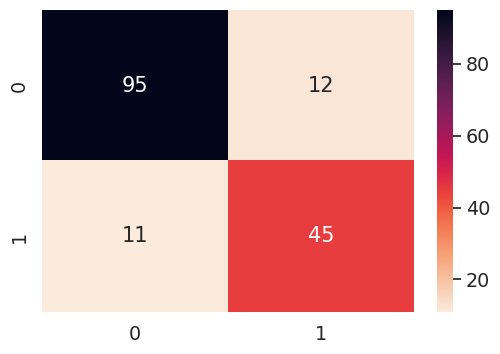

In [ ]:
# Making the Confusion Matrix
plt.figure(dpi = 100)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap = 'rocket_r')

In [ ]:
#Interpretation:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89       107
         1.0       0.79      0.80      0.80        56

    accuracy                           0.86       163
   macro avg       0.84      0.85      0.84       163
weighted avg       0.86      0.86      0.86       163



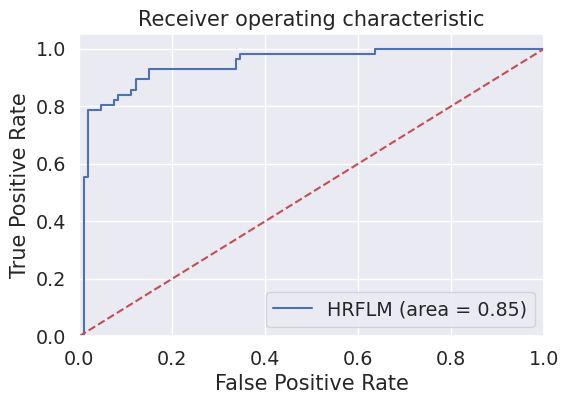

In [ ]:
#ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(dpi=100)
plt.plot(fpr, tpr, label='HRFLM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
p = L.predict(np.array(rand_test).reshape(1, -1))

if p == 0:
  print("Patient does not have PCOS")
  print("But it is always good to eat right, be fit and get adequate sleep!")
else:
  print("Patient has PCOS")
  print("Fear not! Here are a list of experts who could be contacted to solve PCOS as quickly as possible:")
  print("1. Rvela Naik\n2. Prathiba Chauhan\n3. Mano Shankar")

Patient has PCOS
Fear not! Here are a list of experts who could be contacted to solve PCOS as quickly as possible:
1. Rvela Naik
2. Prathiba Chauhan
3. Mano Shankar
